In [5]:
# Script Final — Classificação de Pagadores: Padronização + PCA + Modelo

# =============================
# 1. IMPORTAÇÕES
# =============================

# === PACOTES  ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.pipeline import Pipeline


In [7]:
# =============================
# 2. Carregamento dos Dados
# =============================

df = pd.read_csv("C:/Users/domin/Downloads/dados (1).csv", index_col=0)
print("\nDados carregados:", df.shape)



Dados carregados: (2100, 52)



Distribuição das classes:
class
0    0.619048
1    0.380952
Name: proportion, dtype: float64


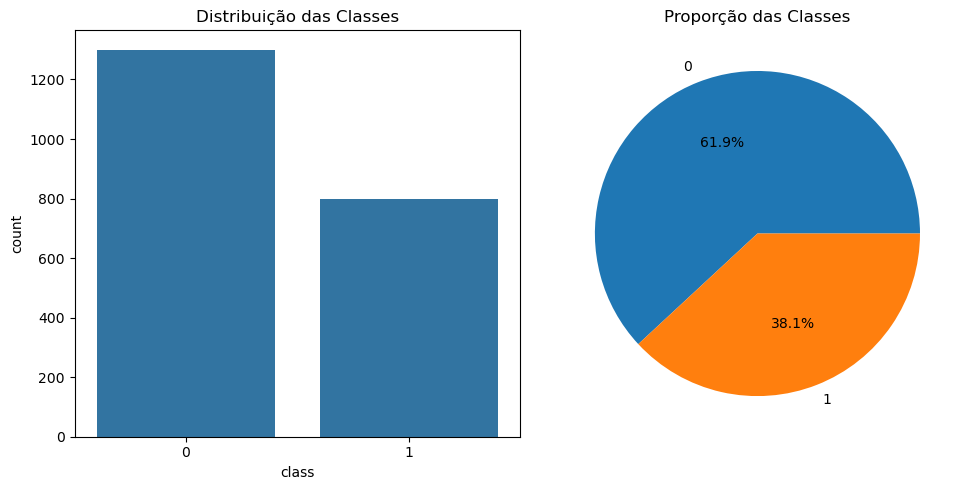

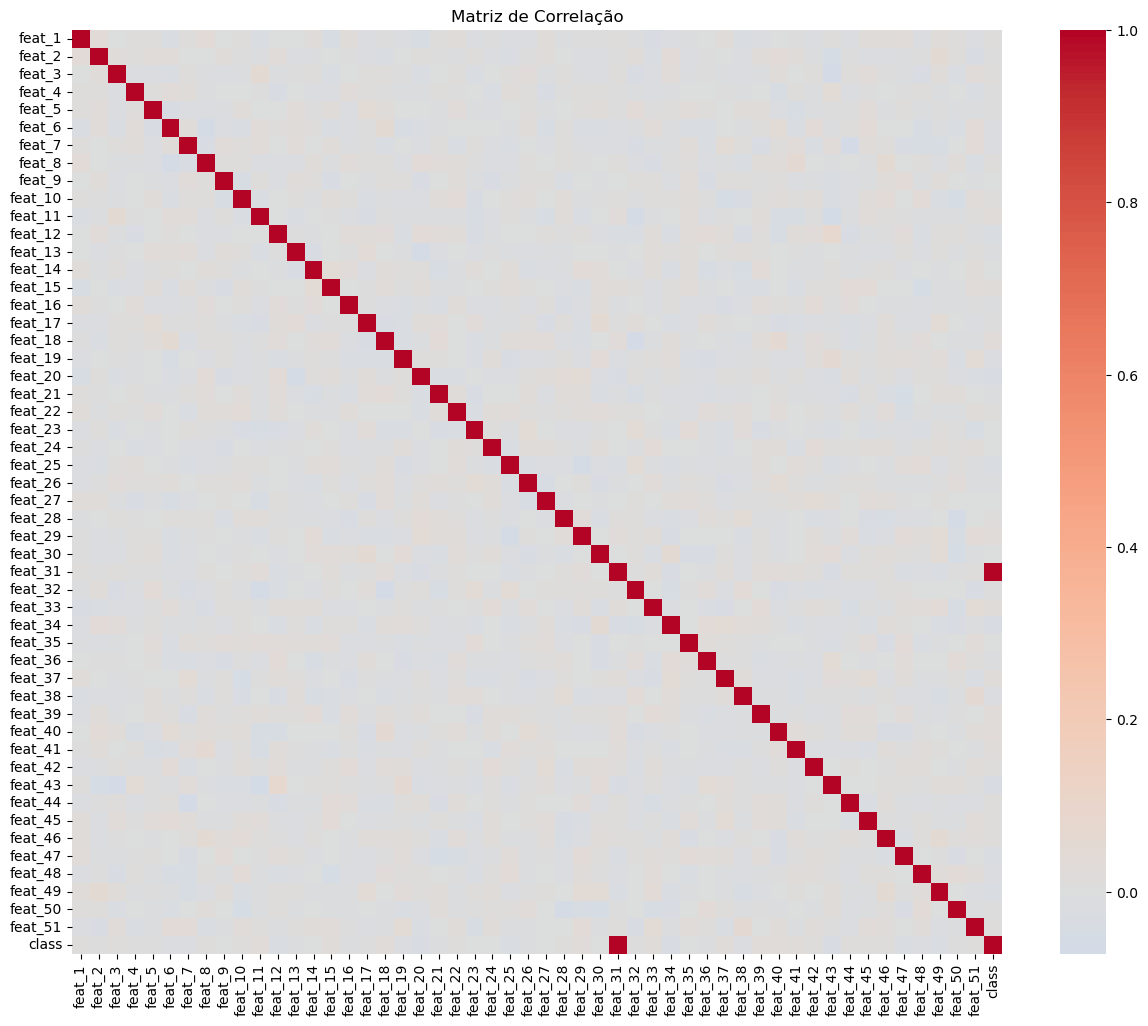

In [9]:
# ==================================
# 3. ANÁLISE ESTATÍSTICA DESCRITIVA 
# ==================================

print("\nDistribuição das classes:")
class_dist = df['class'].value_counts(normalize=True)
print(class_dist)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='class', data=df)
plt.title('Distribuição das Classes')

plt.subplot(1, 2, 2)
plt.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%')
plt.title('Proporção das Classes')
plt.tight_layout()
plt.show()

# Análise de correlação
plt.figure(figsize=(15, 12))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.show()


In [11]:
# =====================================
# 4. DIVISÃO DOS DADOS OU EM FEATURES
# =====================================

X = df.drop('class', axis=1)
y = df['class']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

print(f"\nDivisão dos dados:")
print(f"Treino: {X_train.shape[0]} amostras")
print(f"Validação: {X_val.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")



Divisão dos dados:
Treino: 1260 amostras
Validação: 420 amostras
Teste: 420 amostras


In [13]:
# =============================
# 5.  PIPELINE
# =============================

def create_pipeline(model):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=30)),
        ('model', model)
    ])


In [15]:
# ===================================
# 6. USO DOS MODELOS DE CLASSIFICAÇÃO
# ===================================

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),  # Não aceita class_weight
    "SVM Linear": SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42)
}

In [17]:
# =============================
# 7. FUNÇÃO DE AVALIAÇÃO
# =============================

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name, threshold=0.5):
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)

    y_proba = pipeline.predict_proba(X_val)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    metrics = {
        'Acurácia': accuracy_score(y_val, y_pred),
        'Precisão': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1-score': f1_score(y_val, y_pred),
        'AUC-ROC': roc_auc_score(y_val, y_proba)
    }

    plt.figure()
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.show()

    RocCurveDisplay.from_estimator(pipeline, X_val, y_val)
    plt.title(f'Curva ROC - {model_name}')
    plt.show()

    PrecisionRecallDisplay.from_estimator(pipeline, X_val, y_val)
    plt.title(f'Curva Precision-Recall - {model_name}')
    plt.show()

    return metrics, pipeline
    


=== Avaliação dos Modelos ===

Avaliando Logistic Regression...


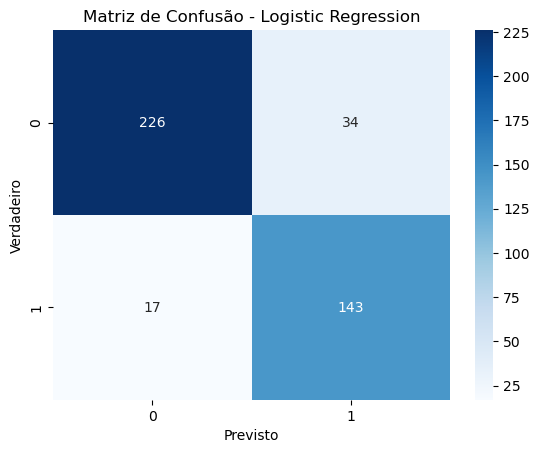

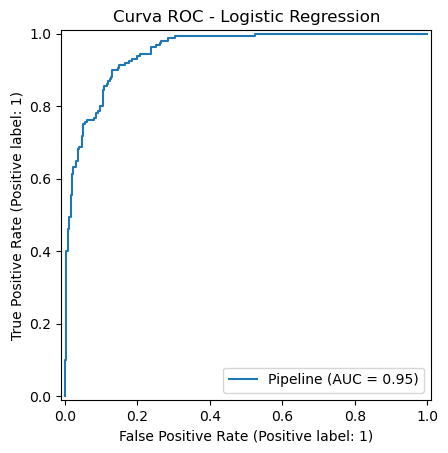

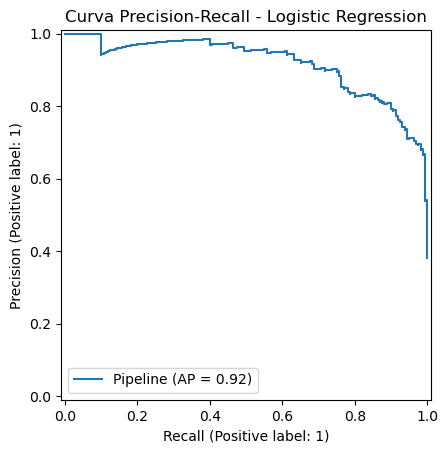


Avaliando Random Forest...


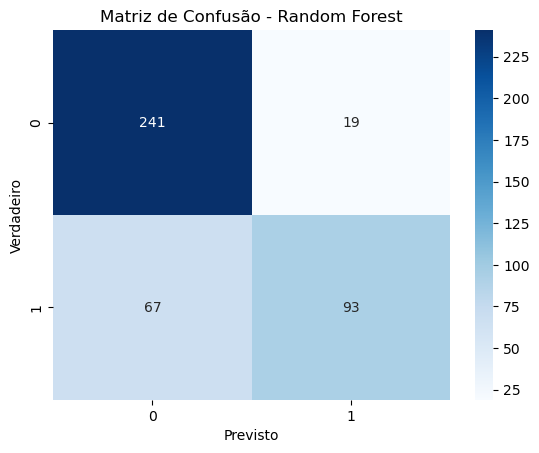

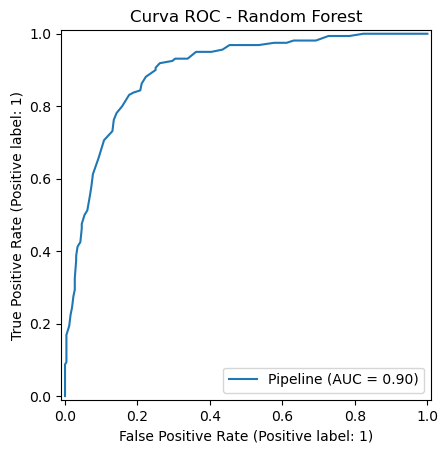

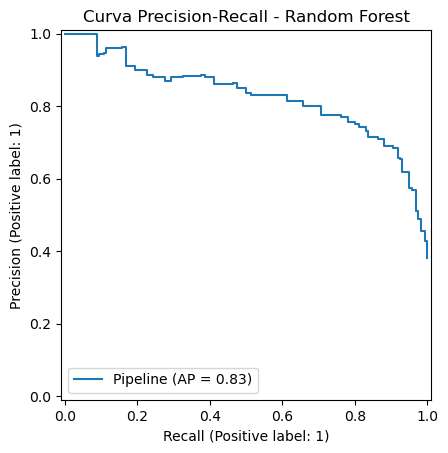


Avaliando Gradient Boosting...


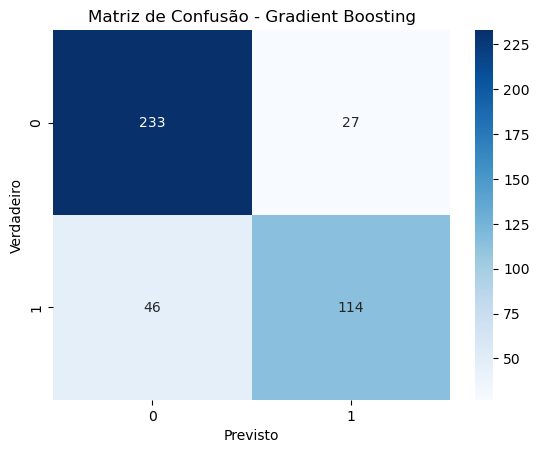

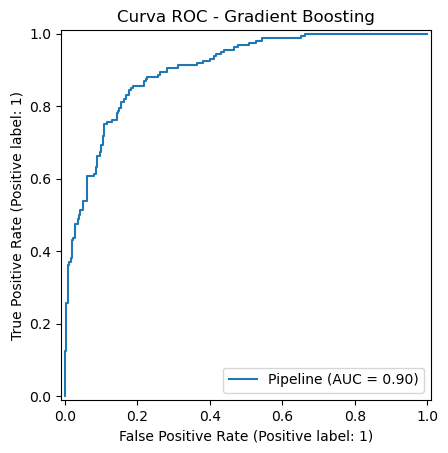

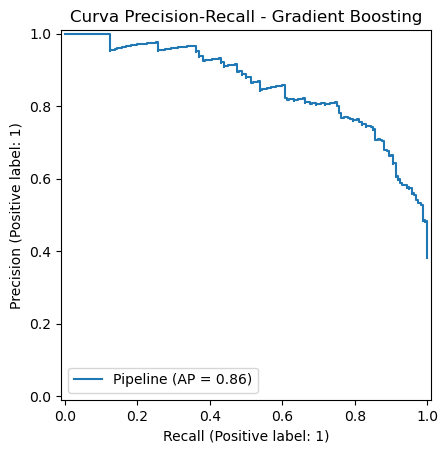


Avaliando SVM Linear...


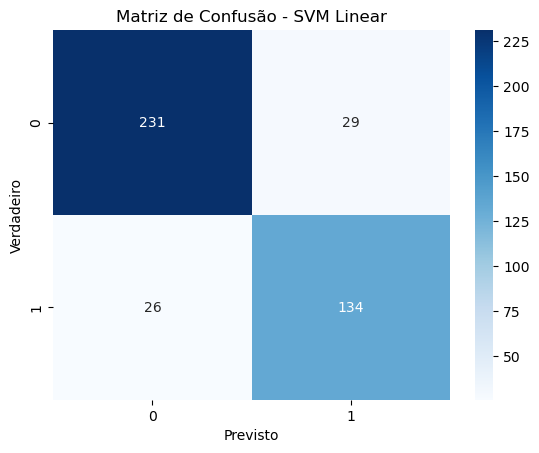

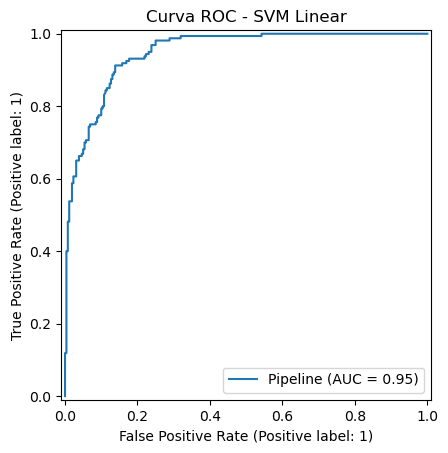

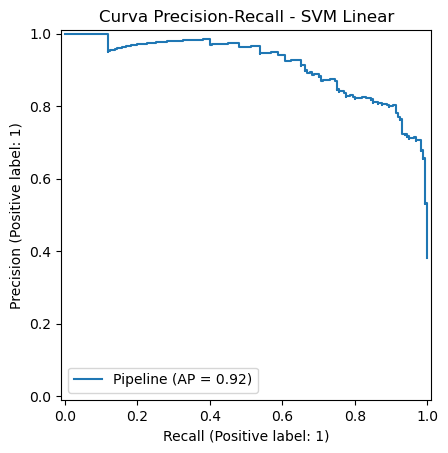


Avaliando Decision Tree...


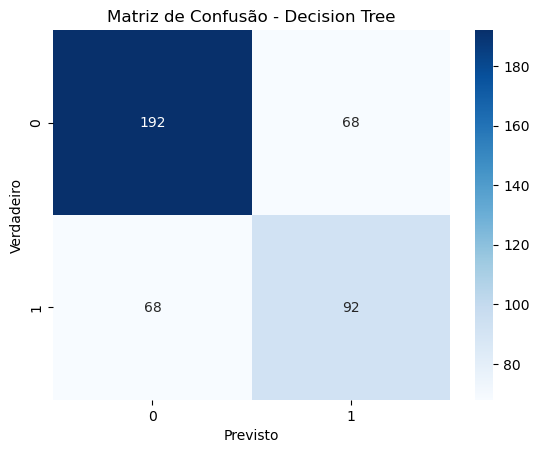

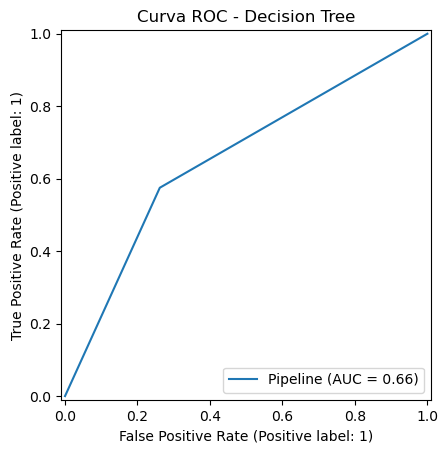

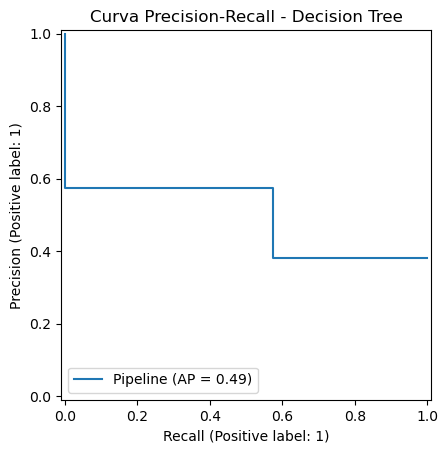


Resultados na Validação:
                     Acurácia  Precisão   Recall  F1-score   AUC-ROC
Modelo                                                              
Logistic Regression  0.878571  0.807910  0.89375  0.848665  0.951226
SVM Linear           0.869048  0.822086  0.83750  0.829721  0.948714
Gradient Boosting    0.826190  0.808511  0.71250  0.757475  0.902933
Random Forest        0.795238  0.830357  0.58125  0.683824  0.896827
Decision Tree        0.676190  0.575000  0.57500  0.575000  0.656731


In [19]:
# =================================
# 8. AVALIAÇÃO DE TODOS OS MODELOS
# =================================

results = []
best_model = None
best_auc = 0
best_pipeline = None

print("\n=== Avaliação dos Modelos ===")
for name, model in models.items():
    print(f"\nAvaliando {name}...")
    metrics, pipeline = evaluate_model(model, X_train, y_train, X_val, y_val, name)
    results.append({'Modelo': name, **metrics})

    if metrics['AUC-ROC'] > best_auc:
        best_auc = metrics['AUC-ROC']
        best_model = name
        best_pipeline = pipeline

results_df = pd.DataFrame(results).set_index('Modelo')
print("\nResultados na Validação:")
print(results_df.sort_values('AUC-ROC', ascending=False))



Melhor modelo: Logistic Regression (AUC = 0.9512)

Métricas no Teste:
                     Acurácia  Precisão   Recall  F1-score   AUC-ROC
Logistic Regression  0.854762  0.796407  0.83125  0.813456  0.941034


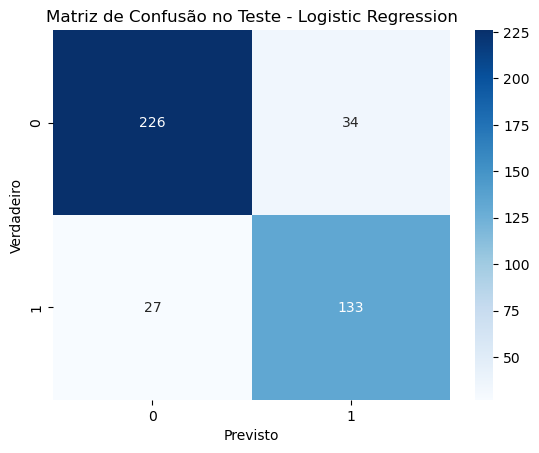

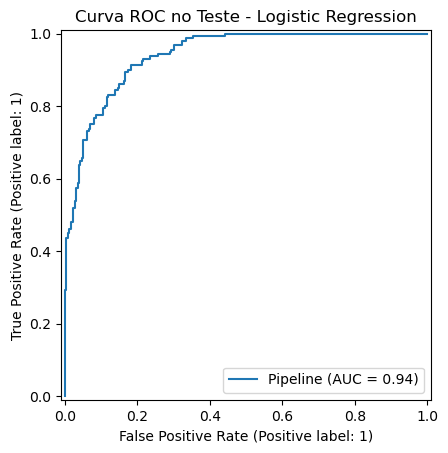

In [21]:
# =============================
# 9.AVALIAÇÃO FINAL NO TESTE
# =============================

print(f"\nMelhor modelo: {best_model} (AUC = {best_auc:.4f})")

y_test_proba = best_pipeline.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

test_metrics = {
    'Acurácia': accuracy_score(y_test, y_test_pred),
    'Precisão': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1-score': f1_score(y_test, y_test_pred),
    'AUC-ROC': roc_auc_score(y_test, y_test_proba)
}

print("\nMétricas no Teste:")
print(pd.DataFrame([test_metrics], index=[best_model]))

plt.figure()
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusão no Teste - {best_model}')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

RocCurveDisplay.from_estimator(best_pipeline, X_test, y_test)
plt.title(f'Curva ROC no Teste - {best_model}')
plt.show()



=== Análise dos Componentes Principais (PCA) ===


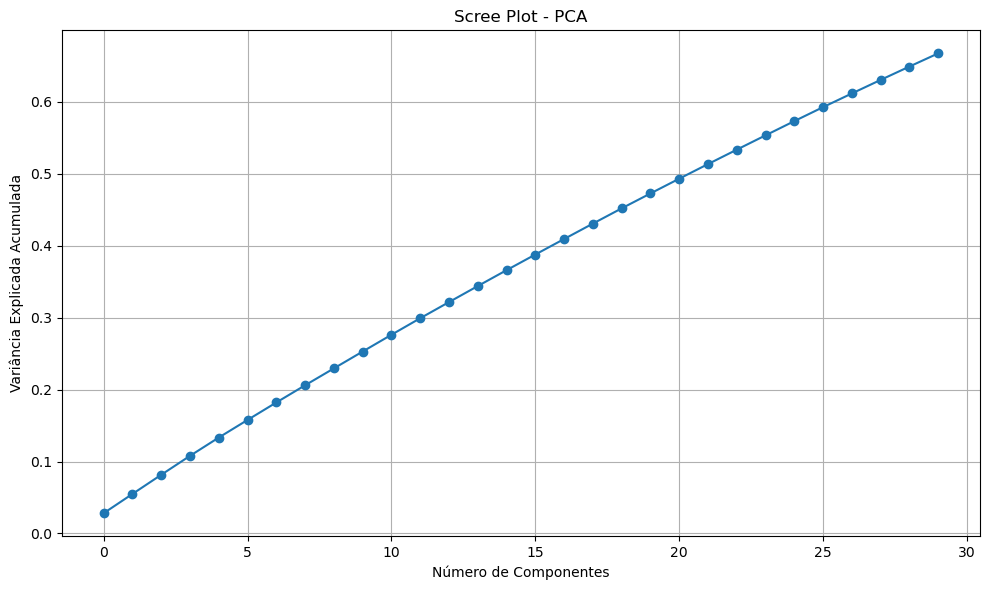

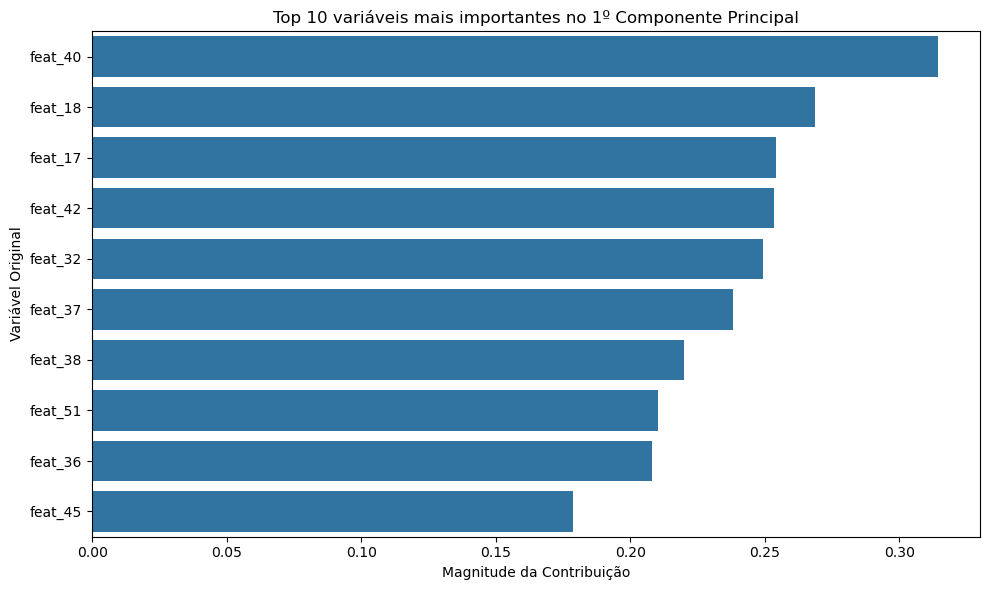

In [23]:
# =============================
# 10. Análise do PCA
# =============================

print("\n=== Análise dos Componentes Principais (PCA) ===")

pca = best_pipeline.named_steps['pca']

# Variância explicada
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Scree Plot - PCA')
plt.grid(True)
plt.tight_layout()
plt.show()

# Top 10 variáveis no PC1
components = pca.components_
feature_names = X_train.columns
pc1_weights = components[0]
pc1_contrib = pd.Series(np.abs(pc1_weights), index=feature_names)
top10_pc1 = pc1_contrib.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top10_pc1.values, y=top10_pc1.index)
plt.title("Top 10 variáveis mais importantes no 1º Componente Principal")
plt.xlabel("Magnitude da Contribuição")
plt.ylabel("Variável Original")
plt.tight_layout()
plt.show()
